# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999

# Load JSON

In [3]:
cards = pd.read_json('AllCards.json')

In [4]:
cards = cards.transpose()

In [5]:
cards.columns

Index(['colorIdentity', 'colorIndicator', 'colors', 'convertedManaCost',
       'edhrecRank', 'faceConvertedManaCost', 'foreignData', 'hand',
       'hasLeadershipSkills', 'hasNoDeckLimit', 'isReserved', 'layout',
       'leadershipSkills', 'legalities', 'life', 'loyalty', 'manaCost',
       'mtgArenaId', 'mtgoFoilId', 'mtgoId', 'mtgstocksId', 'name', 'names',
       'power', 'printings', 'purchaseUrls', 'rulings', 'scryfallOracleId',
       'side', 'subtypes', 'supertypes', 'text', 'toughness', 'type', 'types',
       'uuid'],
      dtype='object')

# Data cleaning

## Only select monocolored cards

In [6]:
# Each card's colors is stored in list form, with colorless cards having an empty list.
monocolored = pd.Series([len(cards.colors[i])<=1 for i in range(len(cards.colors))])
monocolored.index = cards.index
monocolor = cards.copy()
monocolor = monocolor[monocolored]

In [7]:
monocolor.shape

(18093, 36)

In [8]:
monocolor.drop(columns=['colorIdentity','colorIndicator','edhrecRank','faceConvertedManaCost',
                        'foreignData','hand','hasLeadershipSkills','hasNoDeckLimit','isReserved',
                        'leadershipSkills','legalities','life','loyalty','manaCost','mtgArenaId',
                        'mtgoFoilId','mtgoId', 'name','names','purchaseUrls','rulings',
                        'scryfallOracleId','side','supertypes','subtypes','type','uuid'], inplace=True)

In [9]:
monocolor.head()

,colors,convertedManaCost,layout,mtgstocksId,power,printings,text,toughness,types
"""Flying With Scissors""",[U],3,normal,NaN,2,[ELD],Flying,3,[Creature]
"""Griffin Wants Zoomies""",[W],3,normal,NaN,2,[ELD],"Flying\nWhenever ""Griffin Wants Zoomies"" attac...",2,[Creature]
"""Rowan's Badass Sidekick""",[R],4,normal,NaN,NaN,[ELD],First strike\nAs long as you control a Rowan p...,NaN,[Creature]
"""Rowan's Not Messing Around Anymore""",[R],5,normal,NaN,NaN,[ELD],[+1]: Up to one target creature gets +3/+0 and...,NaN,[Planeswalker]
"""Rowan's Red Riding Hoods""",[R],5,normal,NaN,5,[ELD],"When ""Rowan's Red Riding Hoods"" enters the bat...",2,[Creature]


In [10]:
monocolor.text = monocolor.text.fillna('') # Fill in text for vanilla cards
monocolor.index = monocolor.index.str.strip('"') # Clean the card names

# Change all the colors from lists to strings
monocolor.colors = [color[0] if len(color) == 1 else 'C' for color in monocolor.colors]
# Cards have multiple types in lists as well. Join them into a space separated string.
monocolor.types = [' '.join(t) if len(t) > 1 else t[0] for t in monocolor.types]

In [11]:
color_rename={'B':'Black','R':'Red','C':'Colorless','W':'White','U':'Blue','G':'Green'}
monocolor.replace({'colors':color_rename},inplace=True)

## Only select cards that were played in standard
### Scrape for list of sets that were in standard

In [12]:
from bs4 import BeautifulSoup as bs
import requests

In [13]:
html_page = requests.get('https://mtg.gamepedia.com/Template:List_of_Magic_sets')

In [14]:
soup = bs(html_page.content,'html.parser')

In [15]:
table = soup.findAll('tr')

In [16]:
standard = [row.findAll('td')[3].text for row in table[1:] if (row.findAll('td')[4].text=='Core set') or row.findAll('td')[4].text=='Expansion set']

In [17]:
# I want the three letter set code since that is what the data uses
# Cut off the last 5 since they are sets which are planned for release but not yet released
standard = [s[:3] for s in standard][:-5]

In [18]:
len(standard)

101

### Printings are represented as lists so need to manually create dummies
Cards can have reprints in different sets


<span style="color:red">**No longer creating dummies because the original purpose was to find all keywords ever used in magic and some keywords were block specific. Also a color's identity (what the color's main theme is) might change from set to set so it would also account for that. But now I am only looking at evergreen keywords that are present throughout all sets that have ever been in standard and these color themes stay consistent.**</span>
Now only need to check if the card has ever been in standard

###### <span style='color:red'>Old code to make dummies</span>

In [ ]:
# standard_df = pd.DataFrame(columns=standard,index=monocolor.index).fillna(0)
# standard_df.head()

In [ ]:
# for idx in monocolor.index:
#     for s in monocolor.loc[idx].printings:
#         if s in standard:
#             standard_df.at[idx,s] = 1

In [ ]:
# monocolor = monocolor[standard_df.sum(axis=1) > 0].merge(standard_df,left_index=True,right_index=True)

In [ ]:
# monocolor.head()

###### New code that checks for the number of standard sets the card has been reprinted in

In [19]:
monocolor['standard'] = 0
for idx in monocolor.index:
    for s in monocolor.loc[idx].printings:
        if s in standard:
            monocolor.at[idx,'standard'] += 1
monocolor = monocolor[monocolor.standard>=1]
monocolor.head()

,colors,convertedManaCost,layout,mtgstocksId,power,printings,text,toughness,types,standard
Abandon Hope,Black,2,normal,9511,NaN,[TMP],"As an additional cost to cast this spell, disc...",NaN,Sorcery,1
Abandon Reason,Red,3,normal,31326,NaN,[EMN],Up to two target creatures each get +1/+0 and ...,NaN,Instant,1
Abandoned Outpost,Colorless,0,normal,7027,NaN,[ODY],Abandoned Outpost enters the battlefield tappe...,NaN,Land,1
Abandoned Sarcophagus,Colorless,3,normal,35006,NaN,"[HOU, PHOU]",You may cast nonland cards with cycling from y...,NaN,Artifact,1
Abattoir Ghoul,Black,4,normal,30418,3,"[DDQ, ISD]",First strike\nWhenever a creature dealt damage...,2,Creature,1


In [20]:
monocolor.shape

(16071, 10)

## Clean types
Certain type names were updated over time (e.g. summon = creature and tribals becoming obsolete)

In [21]:
type_replace = {'Tribal Sorcery':'Sorcery','Tribal Enchantment':'Enchantment','Tribal Instant':'Instant',
                'Tribal Artifact':'Artifact'}
monocolor.types.replace(type_replace,inplace=True)

In [22]:
types = ['Sorcery','Instant','Land','Artifact','Creature','Enchantment','Planeswalker']
types_df = pd.DataFrame(columns=types,index=monocolor.index).fillna(0)
types_df.head()

,Sorcery,Instant,Land,Artifact,Creature,Enchantment,Planeswalker
Abandon Hope,0,0,0,0,0,0,0
Abandon Reason,0,0,0,0,0,0,0
Abandoned Outpost,0,0,0,0,0,0,0
Abandoned Sarcophagus,0,0,0,0,0,0,0
Abattoir Ghoul,0,0,0,0,0,0,0


In [23]:
for idx in monocolor.index:
    for t in monocolor.loc[idx].types.split(' '):
        if t in types:
            types_df.at[idx,t] = 1
        else:
            # Checking that no cards have an unexpected type
            print (idx)

In [24]:
types_df.head()

,Sorcery,Instant,Land,Artifact,Creature,Enchantment,Planeswalker
Abandon Hope,1,0,0,0,0,0,0
Abandon Reason,0,1,0,0,0,0,0
Abandoned Outpost,0,0,1,0,0,0,0
Abandoned Sarcophagus,0,0,0,1,0,0,0
Abattoir Ghoul,0,0,0,0,1,0,0


In [25]:
monocolor = monocolor[types_df.sum(axis=1) > 0].merge(types_df,left_index=True,right_index=True)

In [26]:
monocolor.head()

,colors,convertedManaCost,layout,mtgstocksId,power,printings,text,toughness,types,standard,Sorcery,Instant,Land,Artifact,Creature,Enchantment,Planeswalker
Abandon Hope,Black,2,normal,9511,NaN,[TMP],"As an additional cost to cast this spell, disc...",NaN,Sorcery,1,1,0,0,0,0,0,0
Abandon Reason,Red,3,normal,31326,NaN,[EMN],Up to two target creatures each get +1/+0 and ...,NaN,Instant,1,0,1,0,0,0,0,0
Abandoned Outpost,Colorless,0,normal,7027,NaN,[ODY],Abandoned Outpost enters the battlefield tappe...,NaN,Land,1,0,0,1,0,0,0,0
Abandoned Sarcophagus,Colorless,3,normal,35006,NaN,"[HOU, PHOU]",You may cast nonland cards with cycling from y...,NaN,Artifact,1,0,0,0,1,0,0,0
Abattoir Ghoul,Black,4,normal,30418,3,"[DDQ, ISD]",First strike\nWhenever a creature dealt damage...,2,Creature,1,0,0,0,0,1,0,0


## Selecting monocolor cards that have a normal layout

In [27]:
monocolor = monocolor[monocolor.layout=='normal']
monocolor.shape

(15694, 17)

## Type casting convertedManaCost from float to int

In [28]:
monocolor.convertedManaCost = monocolor.convertedManaCost.astype(int)

## Feature engineering stat ratio and stat total

In [29]:
# Only creatures an certain artifacts have power and toughness. Fill the other cards with -1 which I will check for.
monocolor[['power','toughness']] = monocolor[['power','toughness']].where(~monocolor.power.isnull(),-1)
monocolor.head()

,colors,convertedManaCost,layout,mtgstocksId,power,printings,text,toughness,types,standard,Sorcery,Instant,Land,Artifact,Creature,Enchantment,Planeswalker
Abandon Hope,Black,2,normal,9511,-1,[TMP],"As an additional cost to cast this spell, disc...",-1,Sorcery,1,1,0,0,0,0,0,0
Abandon Reason,Red,3,normal,31326,-1,[EMN],Up to two target creatures each get +1/+0 and ...,-1,Instant,1,0,1,0,0,0,0,0
Abandoned Outpost,Colorless,0,normal,7027,-1,[ODY],Abandoned Outpost enters the battlefield tappe...,-1,Land,1,0,0,1,0,0,0,0
Abandoned Sarcophagus,Colorless,3,normal,35006,-1,"[HOU, PHOU]",You may cast nonland cards with cycling from y...,-1,Artifact,1,0,0,0,1,0,0,0
Abattoir Ghoul,Black,4,normal,30418,3,"[DDQ, ISD]",First strike\nWhenever a creature dealt damage...,2,Creature,1,0,0,0,0,1,0,0


In [30]:
stats_df = pd.DataFrame(columns=['stat_ratio','stat_total'],index=monocolor.index)
for idx in monocolor.index:
    card = monocolor.loc[idx]
    try:
        if int(card.power) >= 0 and int(card.toughness) > 0:
            stats_df.at[idx,'stat_ratio'] = int(card.power)/int(card.toughness)
            stats_df.at[idx,'stat_total'] = int(card.power)+int(card.toughness)
        else:
            stats_df.at[idx,'stat_ratio'] = 0
            stats_df.at[idx,'stat_total'] = 0
    except ValueError:
        # These are all the cards with X costs. Keep the two values as np.nan so that they can be dropped
        continue

In [31]:
monocolor = monocolor.merge(stats_df,left_index=True,right_index=True)

In [32]:
# Drop cards with X costs
monocolor.dropna(inplace=True)
monocolor.shape

(14737, 19)

## Creating features for evergreen keywords only

In [33]:
html_page = requests.get('https://mtg.gamepedia.com/Evergreen')
soup = bs(html_page.content,'html.parser')

In [34]:
import re
keywords = []
table = soup.findAll('table')[3]
for c in range(1,26,5):
    for words in table.findAll('td')[c:c+3]:
        keywords.extend(re.split("\s*,\s*",re.sub("(\[..\])"," ",words.text.strip().lower())))
keywords = list(set(keywords))
keywords[keywords.index('counter')] = 'counter target'
keywords.extend(['draw','destroy','sacrifice','equip','-1/-1','+1/+1'])
print(keywords)

['defender', 'reach', 'trample', 'flying', 'double strike', 'counter target', 'fight', 'deathtouch', 'first strike', 'menace', 'lifelink', 'indestructible', 'vigilance', 'hexproof', 'flash', 'haste', 'scry', 'draw', 'destroy', 'sacrifice', 'equip', '-1/-1', '+1/+1']


In [35]:
keywords_df = pd.DataFrame(columns=keywords,index=monocolor.index).fillna(0)
for idx in monocolor.index:
    card = monocolor.loc[idx]
    for keyword in keywords:
        if keyword == '+1/+1':
            reg = re.compile(r'(\+\d)\/\1')
        elif keyword == '-1/-1':
            reg = re.compile(r'(-\d)\/\1')
        else:
            reg = re.compile(keyword)
        if reg.search(card.text.lower()):
            keywords_df.at[idx,keyword] = 1
keywords_df.head()

,defender,reach,trample,flying,double strike,counter target,fight,deathtouch,first strike,menace,lifelink,indestructible,vigilance,hexproof,flash,haste,scry,draw,destroy,sacrifice,equip,-1/-1,+1/+1
Abandon Hope,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Abandon Reason,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Abandoned Outpost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Abandoned Sarcophagus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Abattoir Ghoul,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
monocolor = monocolor.merge(keywords_df,left_index=True,right_index=True)

In [37]:
monocolor[(keywords_df['+1/+1']==1)].colors.value_counts()

Green        653
White        445
Black        315
Red          255
Colorless    225
Blue         168
Name: colors, dtype: int64

## Get artists from scraping The Gatherer
Certain artists might prefer drawing for a certain color

<span style='color:red'>Takes too long, might come back to this</span>
Also too many artists drew very few cards so the feature might not be good in the end.

In [ ]:
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import TimeoutException
# from time import sleep
# import progressbar

In [ ]:
# artist_df = pd.DataFrame(columns=['artist'],index=monocolor.index).fillna('')

In [ ]:
# driver_options = webdriver.chrome.options.Options()
# prefs = {"profile.managed_default_content_settings.images": 2}
# driver_options.add_experimental_option("prefs", prefs)
# driver = webdriver.Chrome(options=driver_options)
# driver.maximize_window()

# driver.get("https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=382866")
# bar = progressbar.ProgressBar(maxval=len(monocolor), widgets=[progressbar.Bar('=', '[', ']'), ' ',progressbar.Percentage()])
# bar.start()
# counter = 1
# for card in artist_df[(monocolor.layout=='normal')&(artist_df.artist=='')].index:
#     try:
#         search_bar = driver.find_element_by_xpath('//*[@id="ctl00_ctl00_ctl00_SearchControls_CardSearchBoxParent_HeaderCardSearchBox"]')
#         search_bar.clear()
#         search_bar.send_keys(card,Keys.ENTER)
# #         WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CLASS_NAME,'cardlink'))).click()
#         artist = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH,'//*[@id="ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ArtistCredit"]/a')))
#         artist_df.at[card,'artist'] = artist.text
#         sleep(1)
#     except TimeoutException:
#         print('driver broke on',card)
#         driver.close()
#     bar.update(counter)
#     counter += 1
# print('Done')
# driver.close()
# artist_df.head()

In [ ]:
# monocolor.head()

# Visualizations

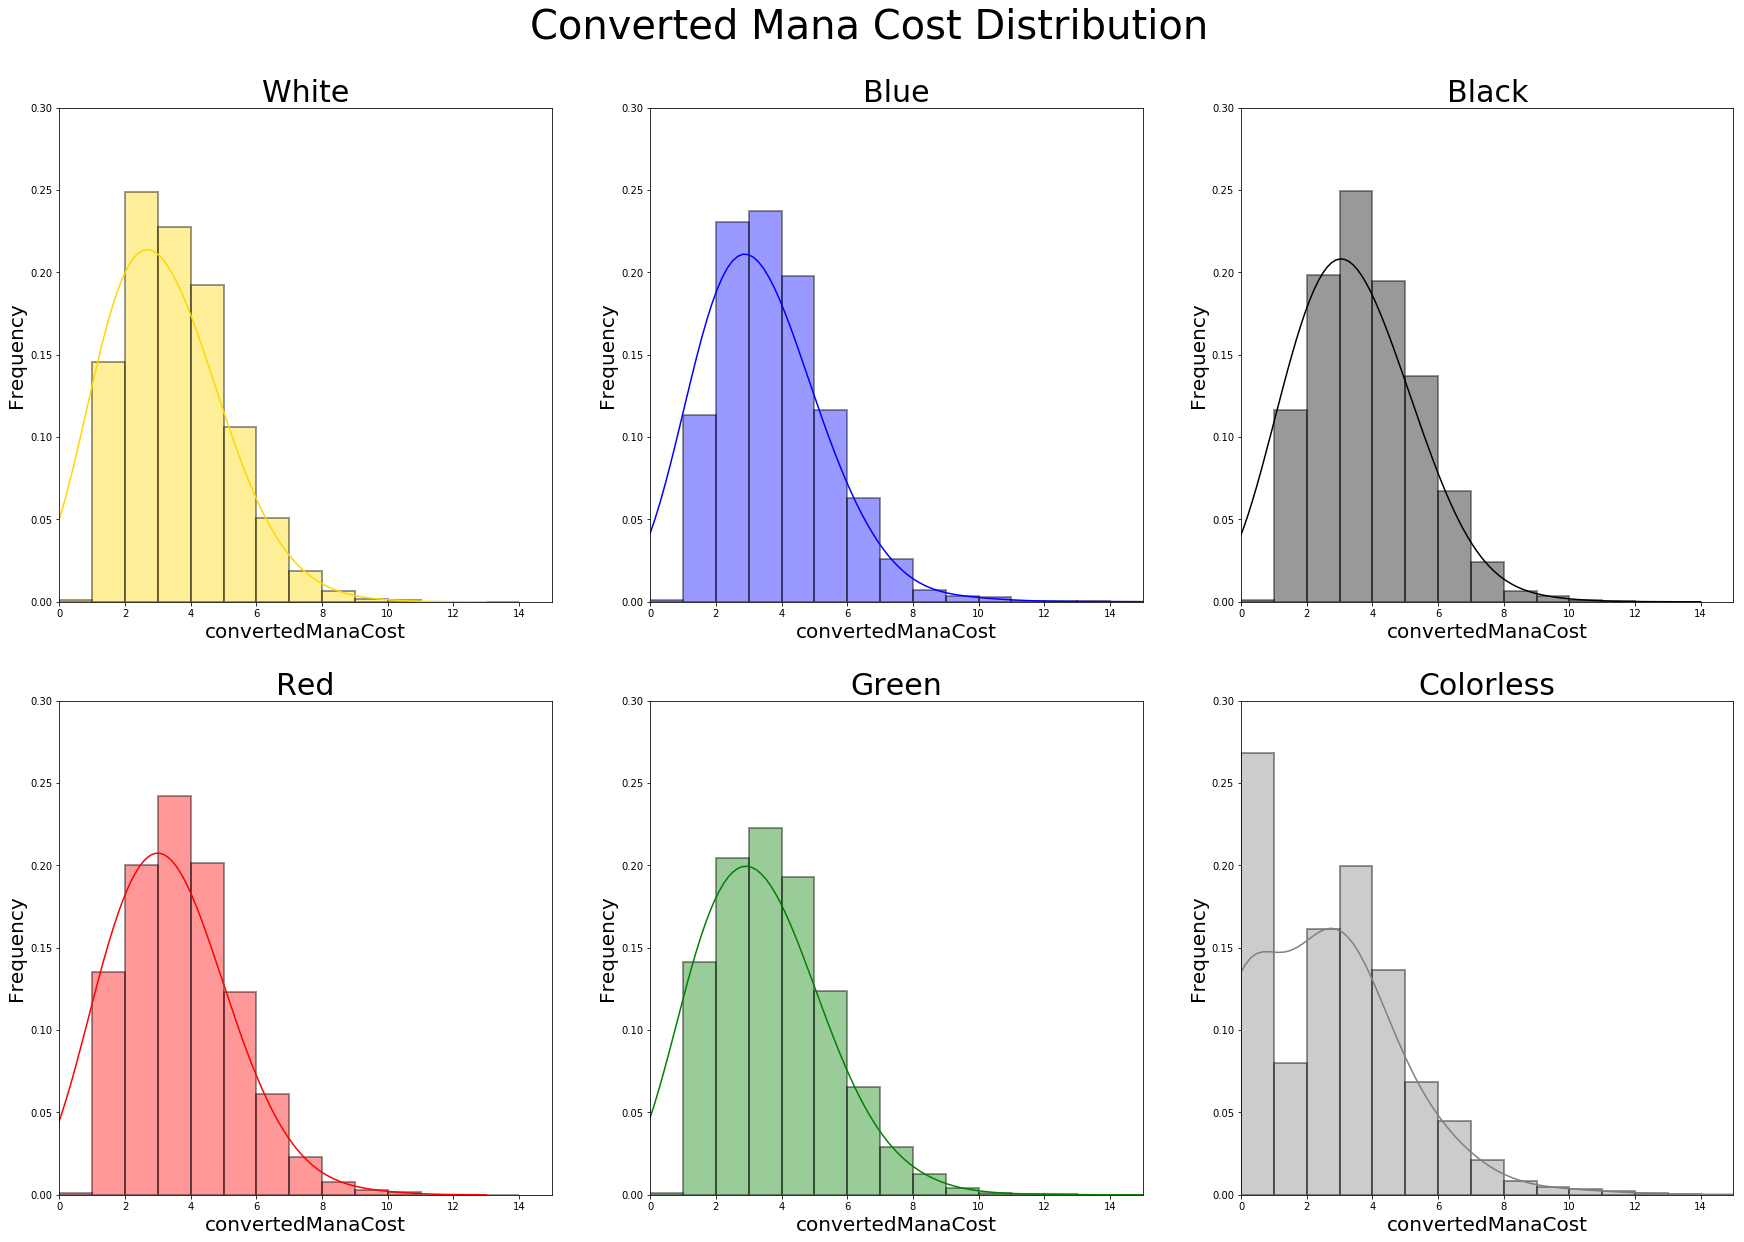

In [38]:
fig, ax = plt.subplots(2,3,figsize=(30,20))
# colors is a list of tuples with (Color indentity,color code,color to use)
colors = [('White','gold'),('Blue','blue'),('Black','black'),
          ('Red','red'),('Green','green'),('Colorless','grey')]

for idx in range(len(colors)):
    curr = ax[idx//3][idx%3]
    curr.set_title(colors[idx][0],size=30)
    curr.set_ylabel('Frequency',size=20)
    curr.set_xlabel('Converted Mana Cost',size=20)
    curr.set_ylim(0,.3)
    curr.set_xlim(0,15)
    sns.distplot(monocolor[monocolor.colors==colors[idx][0]].convertedManaCost, bins=np.arange(0,15),
                 kde_kws={'bw':1},hist_kws=dict(edgecolor="black", linewidth=2), color=colors[idx][1],ax = curr)

fig.suptitle('Converted Mana Cost Distribution',size=40,y=0.95)
plt.show()

In [39]:
def plot_feature_dist(feature):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(feature.title()+' color distribution'.title(),size=20)
    counts = monocolor[monocolor[feature]==1].colors.value_counts()
    ax = sns.barplot(x=counts.index,y=counts,order=['White','Blue','Black','Red','Green','Colorless'],
                     palette=['gold','blue','black','red','green','grey'],
                     edgecolor="black", linewidth=1)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
                    p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ax.set_xlabel('Colors',size=10)
    ax.set_ylabel('Frequency',size=10)
    plt.show()

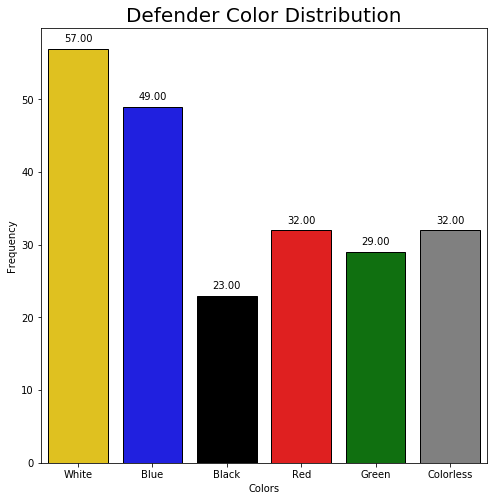

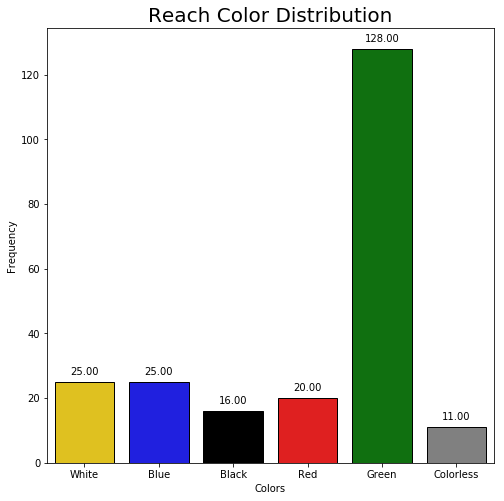

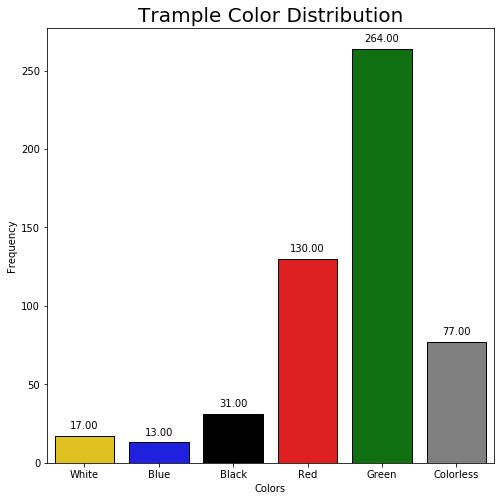

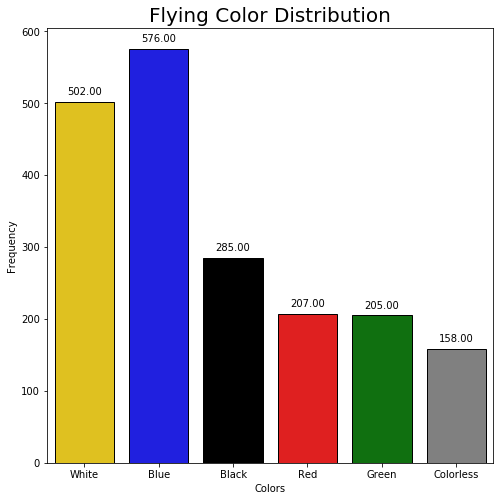

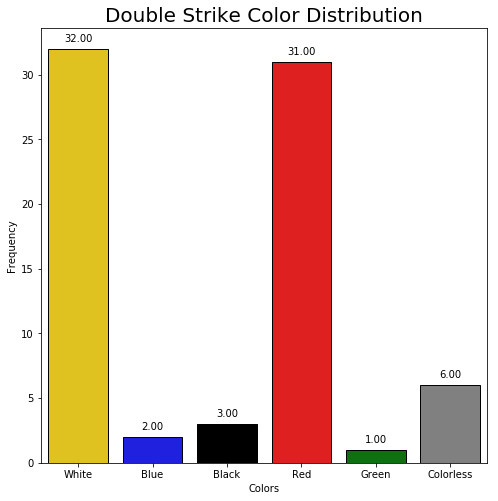

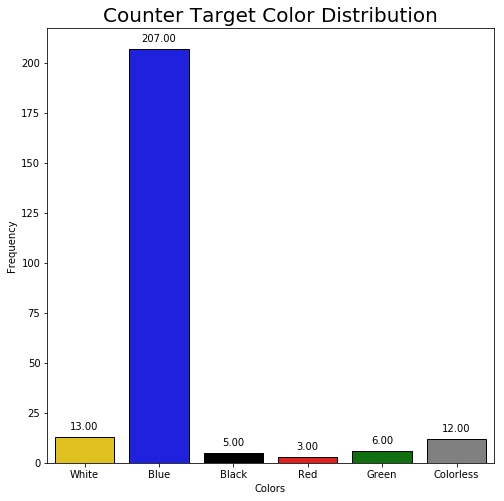

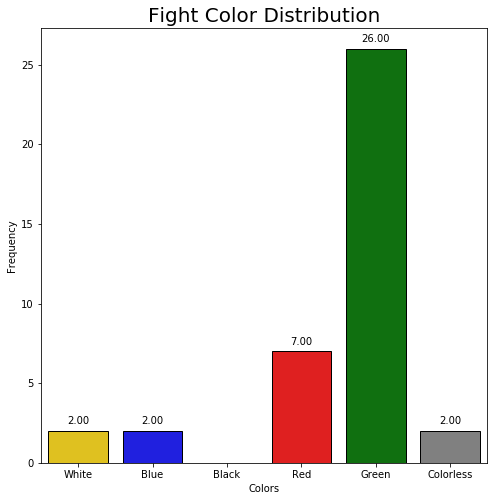

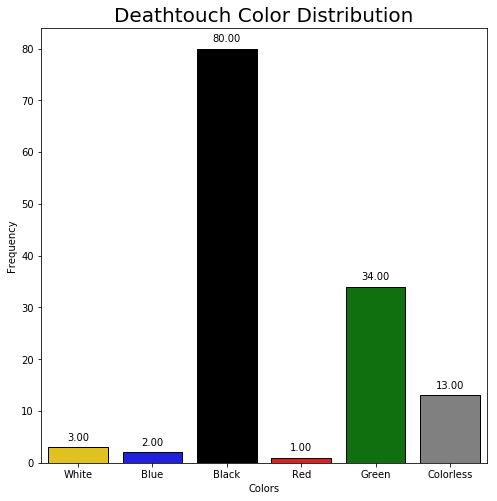

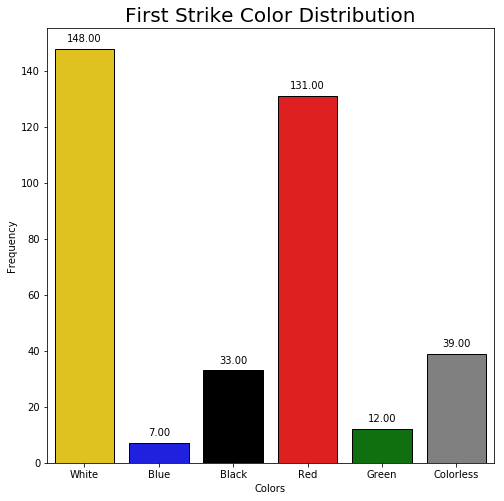

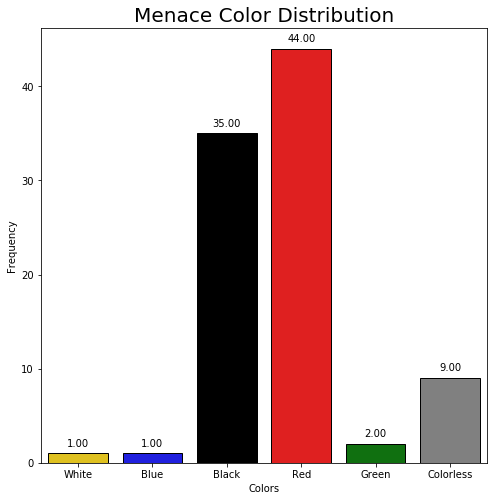

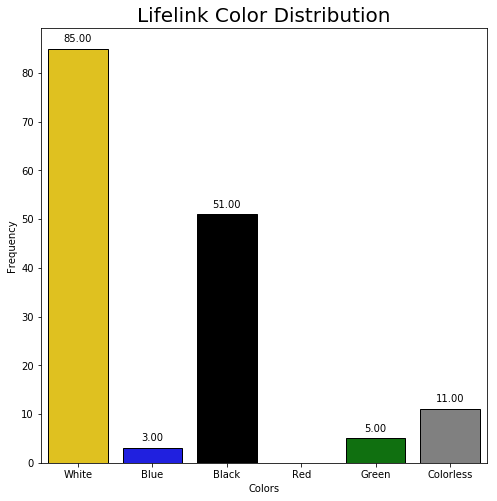

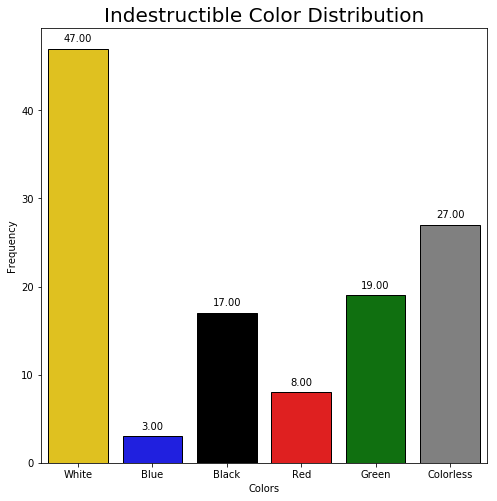

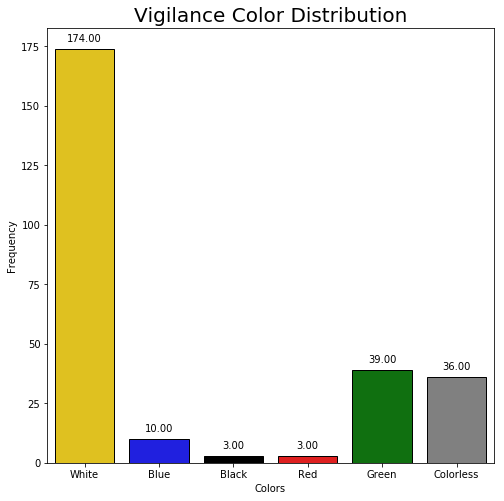

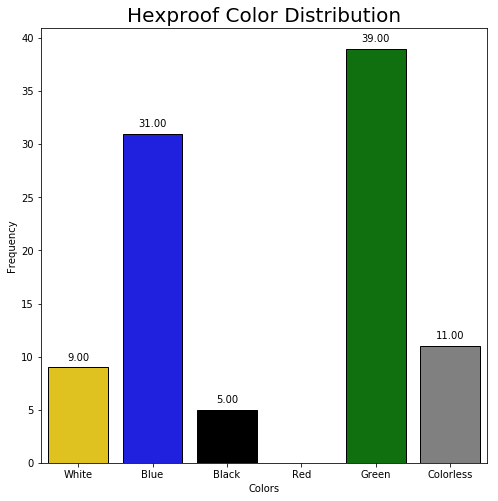

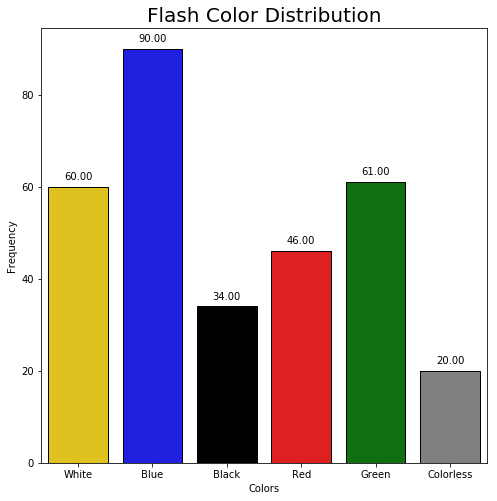

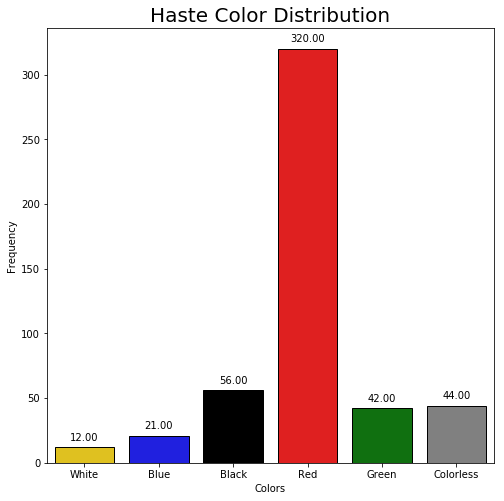

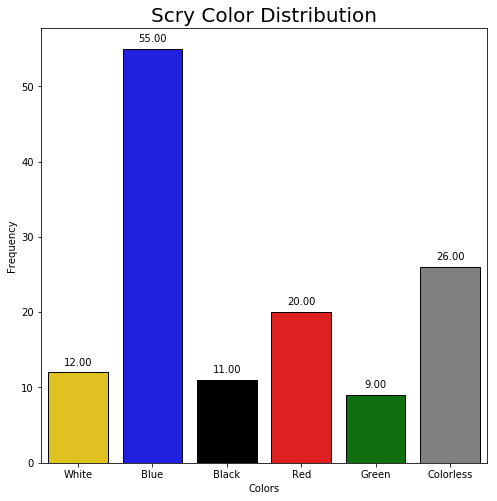

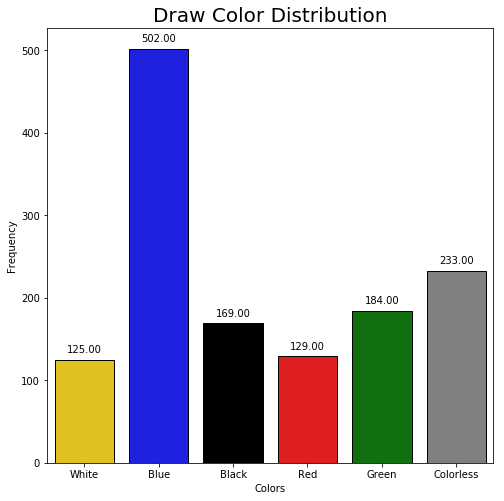

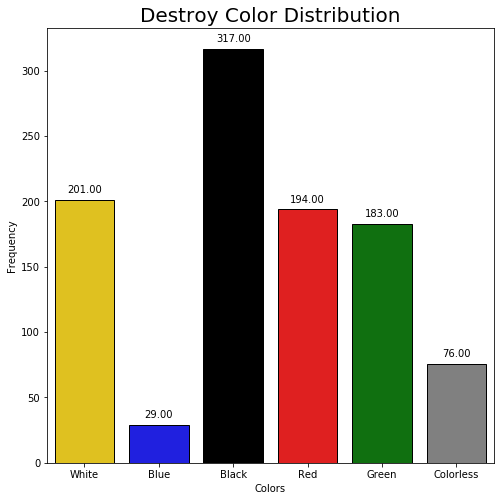

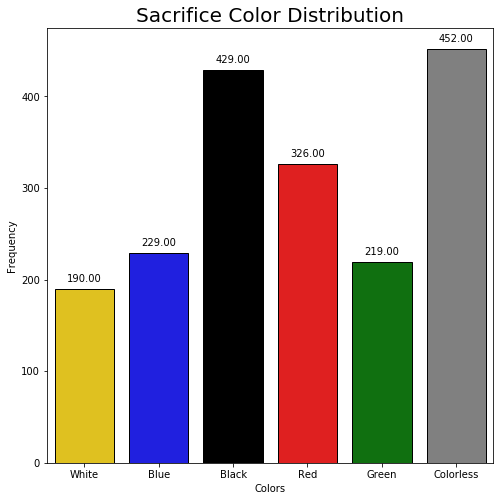

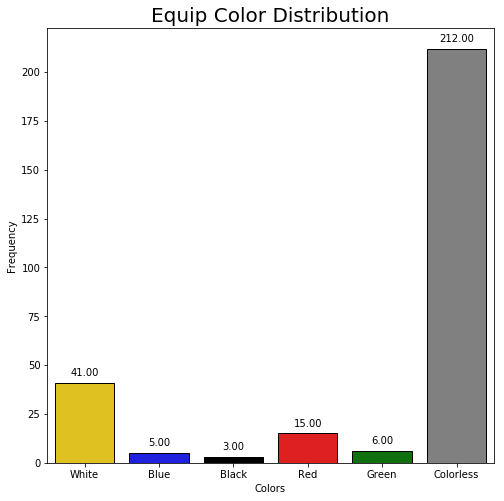

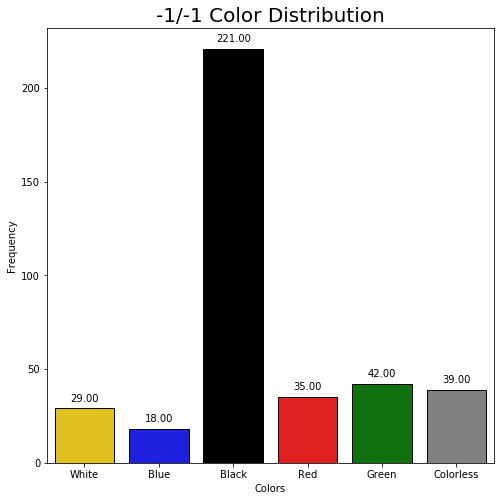

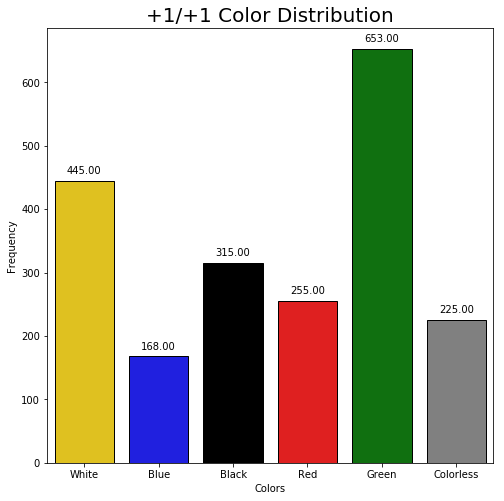

In [40]:
for keyword in keywords:
    plot_feature_dist(keyword)

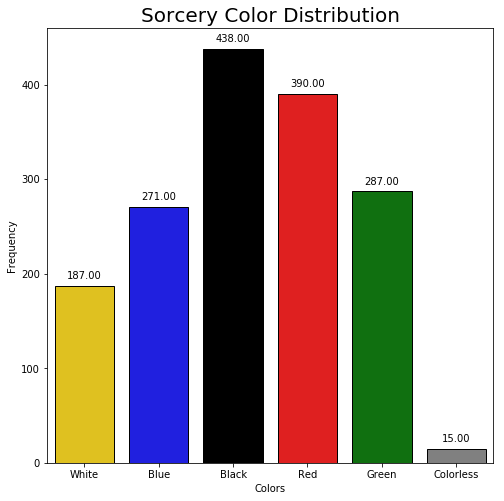

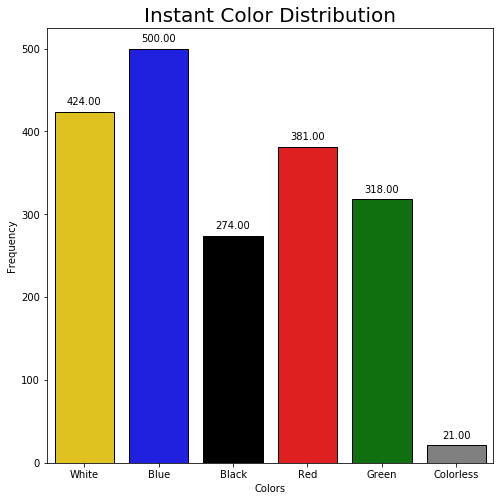

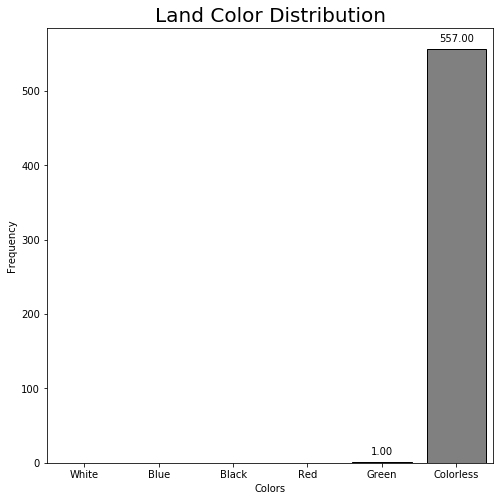

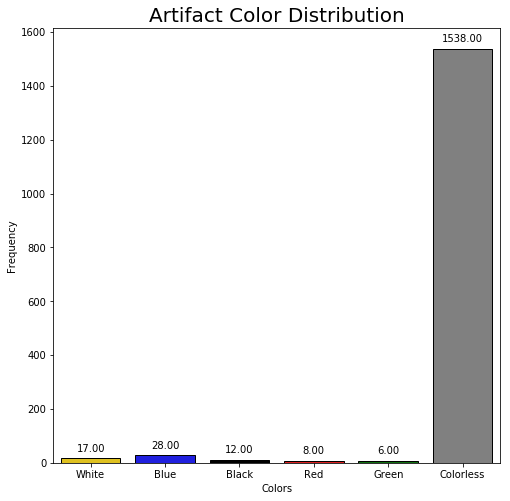

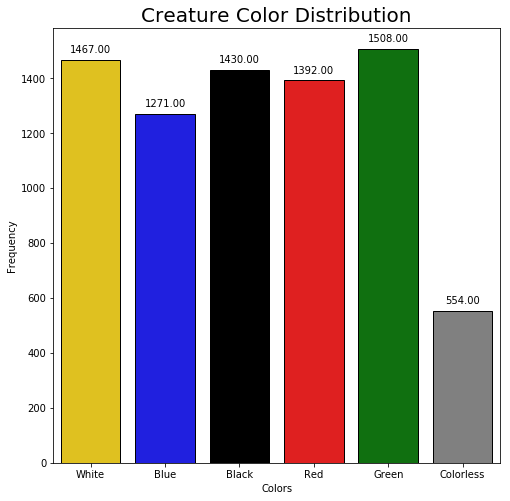

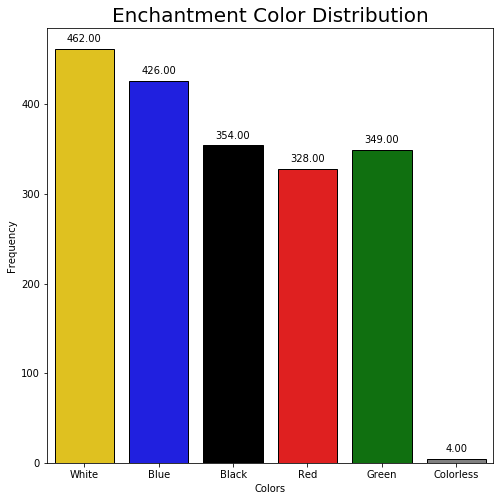

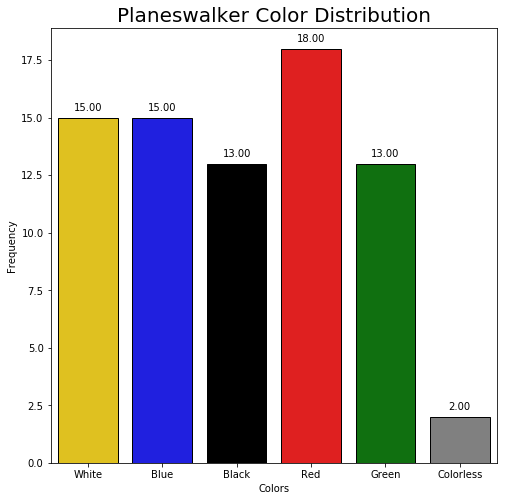

In [41]:
for t in types:
    plot_feature_dist(t)

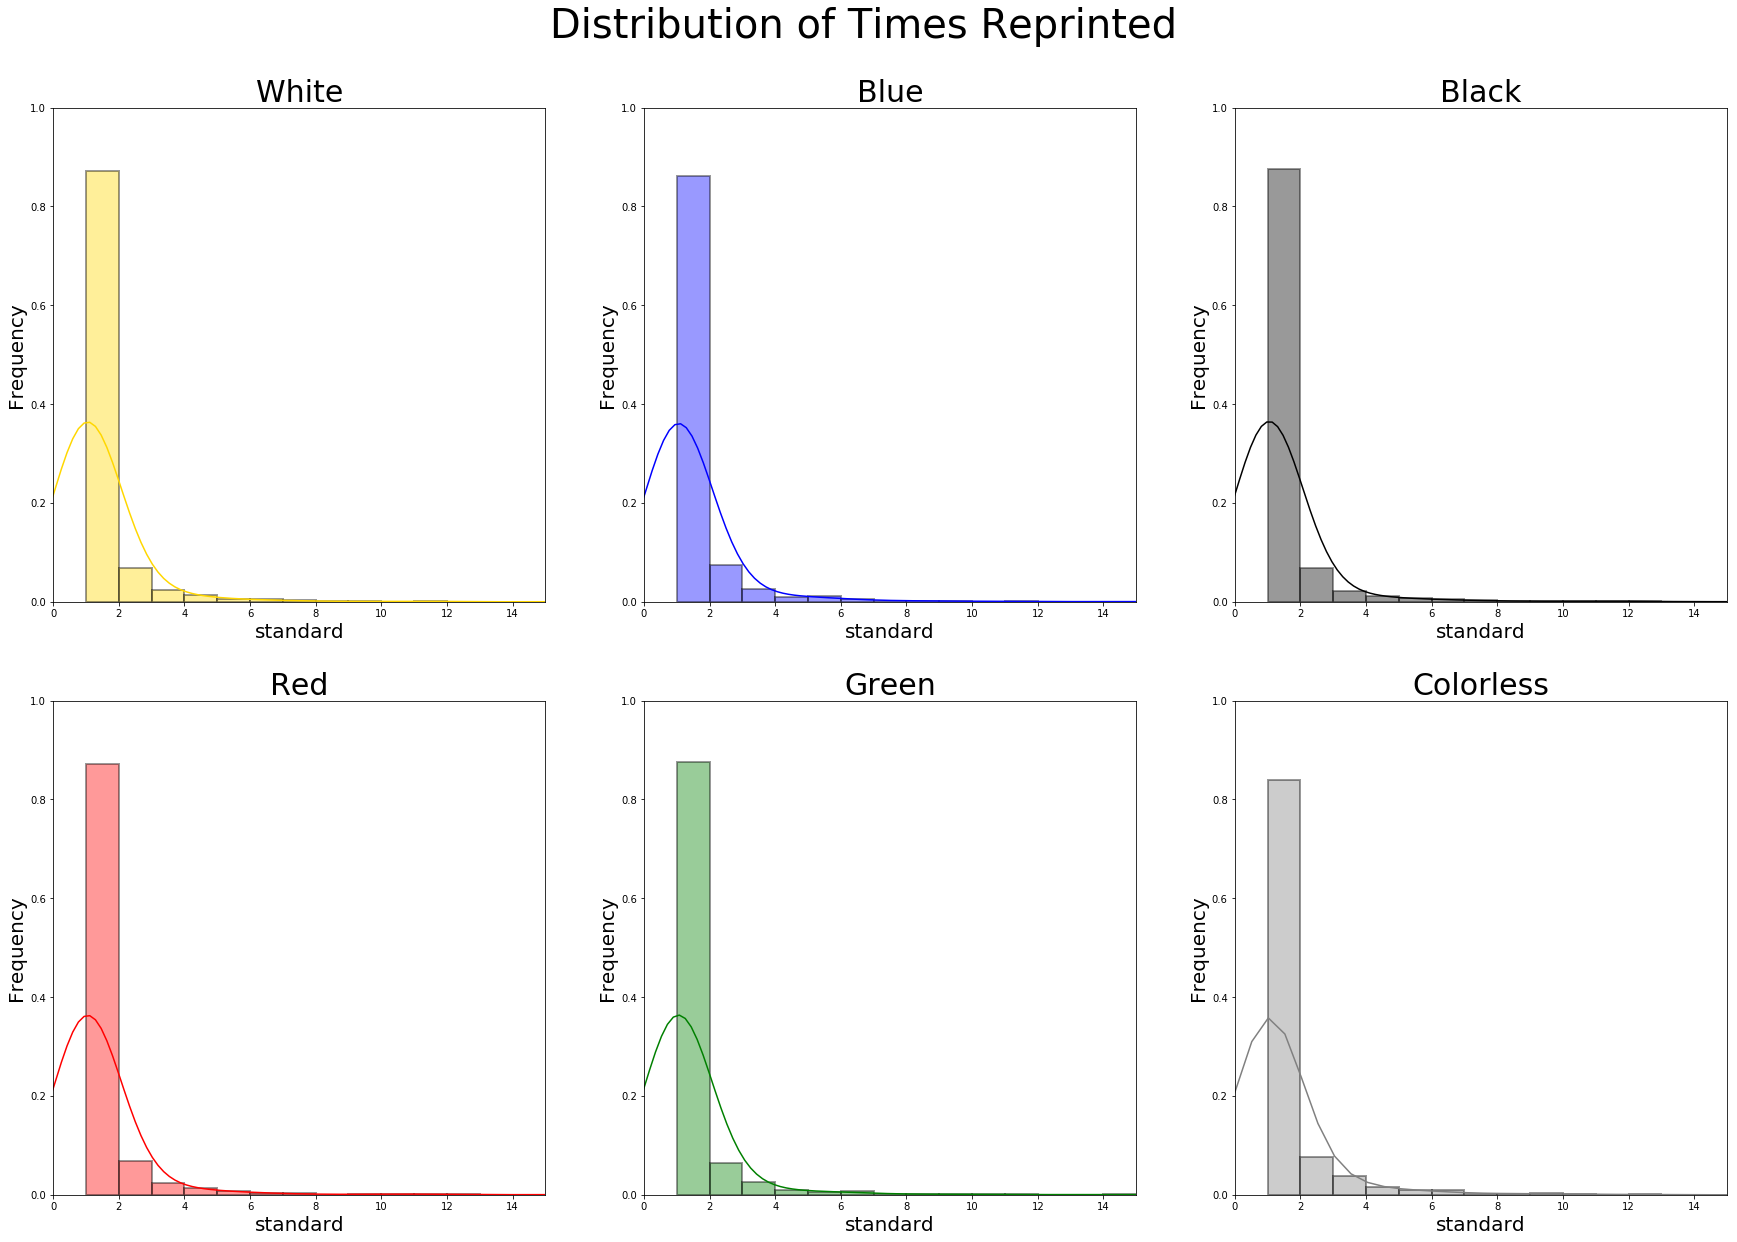

In [42]:
fig, ax = plt.subplots(2,3,figsize=(30,20))
# colors is a list of tuples with (Color indentity,color code,color to use)
colors = [('White','gold'),('Blue','blue'),('Black','black'),
          ('Red','red'),('Green','green'),('Colorless','grey')]

for idx in range(len(colors)):
    curr = ax[idx//3][idx%3]
    curr.set_title(colors[idx][0],size=30)
    curr.set_ylabel('Frequency',size=20)
    curr.set_xlabel('Times Reprinted',size=20)
    curr.set_ylim(0,1)
    curr.set_xlim(0,15)
    sns.distplot(monocolor[monocolor.colors==colors[idx][0]].standard, bins=np.arange(1,20),
                 kde_kws={'bw':1},hist_kws=dict(edgecolor="black", linewidth=2), color=colors[idx][1],ax = curr)

fig.suptitle('Distribution of Times Reprinted',size=40,y=0.95)
plt.show()

# Final cleaning

In [43]:
monocolor.columns

Index(['colors', 'convertedManaCost', 'layout', 'mtgstocksId', 'power',
       'printings', 'text', 'toughness', 'types', 'standard', 'Sorcery',
       'Instant', 'Land', 'Artifact', 'Creature', 'Enchantment',
       'Planeswalker', 'stat_ratio', 'stat_total', 'defender', 'reach',
       'trample', 'flying', 'double strike', 'counter target', 'fight',
       'deathtouch', 'first strike', 'menace', 'lifelink', 'indestructible',
       'vigilance', 'hexproof', 'flash', 'haste', 'scry', 'draw', 'destroy',
       'sacrifice', 'equip', '-1/-1', '+1/+1'],
      dtype='object')

In [44]:
monocolor = monocolor.drop(['layout','mtgstocksId','printings','text','types'],axis=1)

In [45]:
monocolor.stat_ratio = monocolor.stat_ratio.astype(float)
monocolor.stat_total = monocolor.stat_total.astype(int)
monocolor.power = monocolor.power.astype(int)
monocolor.toughness = monocolor.toughness.astype(int)

In [46]:
monocolor.dtypes

colors                object
convertedManaCost      int64
power                  int64
toughness              int64
standard               int64
Sorcery                int64
Instant                int64
Land                   int64
Artifact               int64
Creature               int64
Enchantment            int64
Planeswalker           int64
stat_ratio           float64
stat_total             int64
defender               int64
reach                  int64
trample                int64
flying                 int64
double strike          int64
counter target         int64
fight                  int64
deathtouch             int64
first strike           int64
menace                 int64
lifelink               int64
indestructible         int64
vigilance              int64
hexproof               int64
flash                  int64
haste                  int64
scry                   int64
draw                   int64
destroy                int64
sacrifice              int64
equip         

# Models

In [47]:
y = monocolor['colors']
X = monocolor[monocolor.columns.tolist()[1:]]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds,average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds,average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds,average='macro')))

In [50]:
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(labels, preds):
    results = pd.crosstab(labels, preds, rownames=['True'], colnames=['Predicted'], margins=True)
    print(results)

## Dummy Classifier

In [51]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train,y_train)
dummy_pred = dummy.predict(X_test)

In [52]:
print_metrics(y_test,dummy_pred)

Precision Score: 0.03007688828584351
Recall Score: 0.16666666666666666
Accuracy Score: 0.18046132971506107
F1 Score: 0.05095785440613027


## KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier
KNN1 = KNeighborsClassifier()
KNN1.fit(X_train, y_train)
KNN1_preds = KNN1.predict(X_test)

In [54]:
print_metrics(y_test,KNN1_preds)

Precision Score: 0.4098151380190207
Recall Score: 0.3978450148753639
Accuracy Score: 0.38907734056987786
F1 Score: 0.39936375058508977


In [55]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25, steps = 2):
    k_scores = []
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, steps):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds,average='macro')
        k_scores.append(f1)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
    pd.Series(k_scores,index=np.arange(min_k,max_k+1,steps)).plot()

Best Value for k: 10
F1-Score: 0.4153086949866253


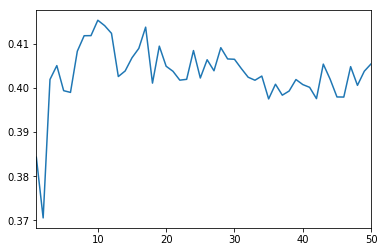

In [56]:
find_best_k(X_train,y_train,X_test,y_test,max_k=50,steps=1)

In [57]:
KNN2 = KNeighborsClassifier(n_neighbors=10)
KNN2.fit(X_train, y_train)
KNN2_preds = KNN2.predict(X_test)

In [58]:
print_metrics(y_test,KNN2_preds)

Precision Score: 0.42510581938517467
Recall Score: 0.4107417436614509
Accuracy Score: 0.40298507462686567
F1 Score: 0.4153086949866253


## Decision Trees

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [60]:
d_tree1 = DecisionTreeClassifier(random_state=10)
d_tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [61]:
d_tree1_pred = d_tree1.predict(X_test)

In [62]:
print('Max Depth:',d_tree1.tree_.max_depth)
print('Node Count:',d_tree1.tree_.node_count)

Max Depth: 39
Node Count: 5563


In [63]:
print_metrics(y_test,d_tree1_pred)

Precision Score: 0.44738363059732206
Recall Score: 0.4470177491783461
Accuracy Score: 0.43826322930800543
F1 Score: 0.44551536954025733


**Just a basic Decision Tree is already performing better than KNN without parameter tuning**

In [64]:
def find_best_depth(X_train, y_train, X_test, y_test, min_depth=1, max_depth=25, steps = 2):
    depth_scores = []
    best_depth = 0
    best_score = 0.0
    for d in range(min_depth, max_depth+1, steps):
        dTree = DecisionTreeClassifier(random_state=10,max_depth=d)
        dTree.fit(X_train, y_train)
        preds = dTree.predict(X_test)
        f1 = f1_score(y_test, preds,average='macro')
        depth_scores.append(f1)
        if f1 > best_score:
            best_depth = d
            best_score = f1
    
    print("Best Value for k: {}".format(best_depth))
    print("F1-Score: {}".format(best_score))
    pd.Series(depth_scores,index=np.arange(min_depth,max_depth+1,steps)).plot()

Best Value for k: 19
F1-Score: 0.45246695619409677


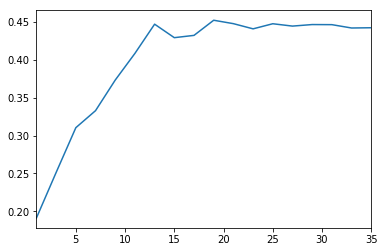

In [65]:
find_best_depth(X_train,y_train,X_test,y_test,max_depth=35)

In [66]:
d_tree2 = DecisionTreeClassifier(random_state=10,max_depth=19)
d_tree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [67]:
d_tree2_pred = d_tree2.predict(X_test)

In [68]:
print_metrics(y_test,d_tree2_pred)

Precision Score: 0.48347539749310614
Recall Score: 0.45881647070223974
Accuracy Score: 0.45081411126187243
F1 Score: 0.45246695619409677


**Slight Improvement when adjusting `max_depth` to 19 from 39**

In [69]:
print(d_tree2.tree_.max_depth,d_tree2.tree_.node_count)

19 2173


In [70]:
def find_best_split(X_train, y_train, X_test, y_test, min_split=0.1, max_split=1.1, steps = 0.1):
    split_scores = []
    best_split = 0
    best_score = 0.0
    for s in np.arange(min_split, max_split, steps):
        dTree = DecisionTreeClassifier(random_state=10,min_samples_split=s)
        dTree.fit(X_train, y_train)
        preds = dTree.predict(X_test)
        f1 = f1_score(y_test, preds,average='macro')
        split_scores.append(f1)
        if f1 > best_score:
            best_split = s
            best_score = f1
    
    print("Best Value for k: {}".format(best_split))
    print("F1-Score: {}".format(best_score))
    pd.Series(split_scores,index=np.arange(min_split,max_split,steps)).plot()

Best Value for k: 0.1
F1-Score: 0.4516953780980979


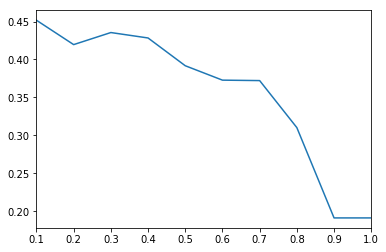

In [71]:
find_best_split(X_train,y_train,X_test,y_test)

In [72]:
d_tree3 = DecisionTreeClassifier(random_state=10,min_samples_split=0.1)
d_tree3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [73]:
d_tree3_pred = d_tree3.predict(X_test)

In [74]:
print_metrics(y_test,d_tree3_pred)

Precision Score: 0.46142923174732403
Recall Score: 0.4575788088358083
Accuracy Score: 0.44674355495251017
F1 Score: 0.4516953780980979


**Changing `min_sample_split` didn't improve the F1 score of the model**

In [75]:
def find_best_params(X_train, y_train, X_test, y_test, min_features=None, max_features=None,min_depth=1,max_depth=25,steps=2):
    if min_features is None:
        min_features = 1
    if max_features is None:
        max_features = X_train.shape[1]
    best_feature = 0
    best_depth = 0
    best_score = 0.0
    for f in range(min_features, max_features, 1):
        for d in range(min_depth, max_depth, steps):
            dTree = DecisionTreeClassifier(random_state=10,max_depth = d, max_features=f)
            dTree.fit(X_train, y_train)
            preds = dTree.predict(X_test)
            f1 = f1_score(y_test, preds,average='macro')
            if f1 > best_score:
                best_feature = f
                best_depth = d
                best_score = f1
    
    print("Best number of features: {}".format(best_feature))
    print("Best Value for depth: {}".format(best_depth))
    print("F1-Score: {}".format(best_score))
#     pd.Series(feature_scores,index=range(min_features, max_features, 1)).plot()

In [76]:
find_best_params(X_train,y_train,X_test,y_test)

Best number of features: 11
Best Value for depth: 23
F1-Score: 0.45727606272752364


In [77]:
d_tree4 = DecisionTreeClassifier(random_state=10,max_depth=15,max_features=12)
d_tree4.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [78]:
d_tree4_pred = d_tree4.predict(X_test)

In [79]:
print_metrics(y_test,d_tree4_pred)

Precision Score: 0.4575150988505307
Recall Score: 0.4492222914583966
Accuracy Score: 0.43724559023066484
F1 Score: 0.4389755126646245


### Prediction Probability with Decision Tree

In [80]:
d_tree4_pred_proba = d_tree4.predict_proba(X_test)

In [81]:
d_tree4_pred_proba

array([[0.1503876 , 0.22790698, 0.02015504, 0.19379845, 0.11937984,
        0.28837209],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.5       , 0.25      , 0.        , 0.25      , 0.        ,
        0.        ],
       ...,
       [0.23022709, 0.1339076 , 0.00861394, 0.17619421, 0.22787784,
        0.22317933],
       [0.18083961, 0.24327234, 0.        , 0.14531755, 0.1883746 ,
        0.24219591],
       [0.1503876 , 0.22790698, 0.02015504, 0.19379845, 0.11937984,
        0.28837209]])

In [82]:
def pred_prob_df(tree,X_test):
    retdf = pd.DataFrame(tree.predict_proba(X_test),columns=d_tree4.classes_,index=X_test.index)
    return retdf

In [83]:
test_probs = pred_prob_df(d_tree4,X_test)

In [84]:
def prob_plot(probs,idx):
    vals = probs.iloc[idx].tolist()
    vals = sorted(vals)
    pal = ['gold' if (x == vals[-1])
           else 'silver' if (x == vals[-2])
           else 'black'
           for x in probs.iloc[idx]]
    bar = sns.barplot(x=test_probs.columns,y=test_probs.iloc[idx],palette = pal)
    bar.set_ylabel('Probability')
    card_name=test_probs.index[idx]
    bar.set_title(card_name+f' ({monocolor.loc[card_name].colors})',size=20)

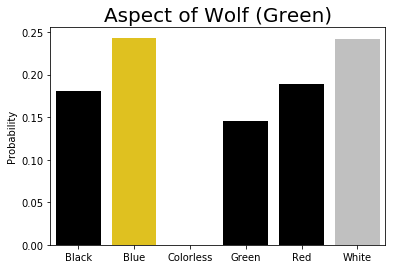

In [85]:
prob_plot(test_probs,7)

## XG Boost

In [86]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

In [ ]:
boost1 = xgb.XGBClassifier()
boost1.fit(X_train, y_train)
boost1_train_preds = boost1.predict(X_train)
boost1_test_preds = boost1.predict(X_test)
training_accuracy = accuracy_score(y_train, boost1_train_preds)
val_accuracy = accuracy_score(y_test, boost1_test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))